In [ ]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
pd.options.display.max_rows =12
import matplotlib.pyplot as plt
import seaborn as sns

#import cdist to find distance for creating circle for each cluster
from scipy.spatial.distance import cdist

# SK-learn libraries for learning.
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

## Import Data

In [ ]:
cleaned_df=pd.read_csv('cleaned_wildfire_data.csv').drop(['Unnamed: 0','_id','Event'],axis=1)
cleaned_df.head()

,Latitude,Longitude,Size,log_sizes,size_category,temperature_14,temperature_13,temperature_12,temperature_11,temperature_10,temperature_9,temperature_8,temperature_7,temperature_6,temperature_5,temperature_4,temperature_3,temperature_2,temperature_1,temperature0,temperature1,temperature2,temperature3,temperature4,temperature5,temperature6,temperature7,temperature8,temperature9,temperature10,temperature11,temperature12,temperature13,temperature14,apparentTemperature_14,apparentTemperature_13,apparentTemperature_12,apparentTemperature_11,apparentTemperature_10,apparentTemperature_9,...,pressure4,pressure5,pressure6,pressure7,pressure8,pressure9,pressure10,pressure11,pressure12,pressure13,pressure14,windSpeed_14,windSpeed_13,windSpeed_12,windSpeed_11,windSpeed_10,windSpeed_9,windSpeed_8,windSpeed_7,windSpeed_6,windSpeed_5,windSpeed_4,windSpeed_3,windSpeed_2,windSpeed_1,windSpeed0,windSpeed1,windSpeed2,windSpeed3,windSpeed4,windSpeed5,windSpeed6,windSpeed7,windSpeed8,windSpeed9,windSpeed10,windSpeed11,windSpeed12,windSpeed13,windSpeed14
0,33.6681,-117.50139,100.0,4.605170,class_d,48.221250,52.325833,55.353750,52.667083,48.797917,45.293333,45.733750,44.997083,42.387083,43.240000,43.841667,44.480417,45.017917,43.213750,43.984583,47.555000,50.182500,45.915000,42.815000,40.652917,36.000000,37.841250,39.242500,43.054167,44.630417,46.715833,50.500417,48.833750,47.974583,48.185417,52.325833,54.967917,52.530417,48.797917,45.193333,...,1014.933750,1016.693333,1016.629167,1020.280000,1025.805417,1021.728750,1019.845000,1022.652500,1020.781250,1020.482500,1021.897083,1.903333,3.202083,2.367083,1.770417,1.282500,2.523750,3.072917,1.957500,2.510833,1.735000,2.923750,2.067083,2.365000,3.145000,8.667083,4.375833,1.159583,1.321250,3.799167,3.646667,2.427500,4.275833,1.949583,2.096250,1.935833,1.428750,2.269583,1.633333,1.618333
1,33.0333,-116.83389,25.0,3.218876,class_c,48.305833,46.069583,44.835417,39.776667,37.474167,41.516667,45.816250,46.633750,48.416667,50.842917,50.914583,49.939167,48.705833,49.097917,57.417917,57.370417,57.896250,56.743750,55.411250,51.923333,53.145833,51.725833,47.428333,45.233750,47.744583,53.589167,66.915417,69.014167,55.660000,48.305833,45.888750,44.176667,39.375417,37.286250,41.100417,...,1016.255833,1017.911250,1019.582500,1019.024583,1015.812500,1017.463750,1022.978333,1022.682917,1021.917917,1018.862917,1015.412500,1.610417,2.541667,2.922917,1.705000,1.704167,2.069167,2.522917,1.399583,2.572083,1.576667,1.460417,1.447083,2.172500,2.212083,9.013333,13.023750,3.148750,1.163750,1.370000,1.526667,1.640417,1.833333,5.261250,4.941250,1.846250,2.011250,7.476250,5.292083,2.992083
2,37.3683,-118.35833,840.0,6.733402,class_e,40.872500,41.335833,49.464583,50.744583,55.579167,47.097083,34.997917,32.290000,35.804167,34.047083,37.159167,51.012500,52.090417,53.058333,52.547917,47.696667,45.990000,46.123750,47.967500,52.187917,58.174167,61.079167,61.387917,57.979167,60.495000,63.239583,64.355833,62.950000,58.552917,38.730417,40.562083,48.921667,50.574583,55.579167,44.856250,...,1015.292083,1013.644167,1013.296667,1015.575417,1017.295000,1015.432917,1011.788750,1010.728333,1009.835417,1011.790000,1010.057917,4.068333,3.552500,4.642917,2.182500,3.190833,8.721250,6.211667,2.771250,4.062917,2.746667,4.042500,2.945417,5.912083,4.874583,6.317500,4.284167,4.330417,4.068750,4.096250,3.337500,2.846250,5.654583,4.394583,2.933750,2.271250,2.413333,2.819167,5.687500,6.950417
3,33.8692,-117.68361,892.0,6.793466,class_e,55.987500,59.727083,60.797917,62.654167,64.841250,62.193333,65.221250,64.035000,58.829167,57.574167,56.907917,55.548333,56.700000,58.230000,63.764583,68.222500,66.819167,59.341250,61.629167,55.850000,55.784583,60.485000,60.504167,58.120000,56.110417,58.985417,61.314583,61.945417,60.759583,55.987500,59.727083,60.797917,62.654167,64.841250,62.193333,...,1016.568750,1013.392917,1016.982083,1018.347917,1016.930833,1016.119583,1014.888333,1016.161250,1016.721667,1016.632083,1017.142500,3.438750,2.363333,2.440000,2.585417,2.431667,2.3

In [ ]:
#Split data into X's (features) and Y's (labels)
X= cleaned_df.drop(columns='size_category')
y= cleaned_df['size_category']

In [ ]:
train_d, dev_d, test_d = np.split(X.sample(frac=1, random_state=42), [int(.6*len(X)), int(.8*len(X))])

In [ ]:
train_d.head()

,Latitude,Longitude,Size,log_sizes,temperature_14,temperature_13,temperature_12,temperature_11,temperature_10,temperature_9,temperature_8,temperature_7,temperature_6,temperature_5,temperature_4,temperature_3,temperature_2,temperature_1,temperature0,temperature1,temperature2,temperature3,temperature4,temperature5,temperature6,temperature7,temperature8,temperature9,temperature10,temperature11,temperature12,temperature13,temperature14,apparentTemperature_14,apparentTemperature_13,apparentTemperature_12,apparentTemperature_11,apparentTemperature_10,apparentTemperature_9,apparentTemperature_8,...,pressure4,pressure5,pressure6,pressure7,pressure8,pressure9,pressure10,pressure11,pressure12,pressure13,pressure14,windSpeed_14,windSpeed_13,windSpeed_12,windSpeed_11,windSpeed_10,windSpeed_9,windSpeed_8,windSpeed_7,windSpeed_6,windSpeed_5,windSpeed_4,windSpeed_3,windSpeed_2,windSpeed_1,windSpeed0,windSpeed1,windSpeed2,windSpeed3,windSpeed4,windSpeed5,windSpeed6,windSpeed7,windSpeed8,windSpeed9,windSpeed10,windSpeed11,windSpeed12,windSpeed13,windSpeed14
648,33.68194,-117.39972,188.0,5.236442,73.776667,73.557917,74.040000,73.537917,72.351250,73.099167,73.358333,69.554167,70.938750,73.073750,74.585833,71.509167,71.213333,71.632083,73.347083,76.708750,78.293333,79.790417,76.527083,72.270417,71.457083,73.182917,74.805833,73.417500,73.948333,74.602083,72.800833,71.053333,67.984583,74.460417,73.815833,74.470833,73.816250,72.513333,73.520417,73.831250,...,1013.225833,1012.362083,1011.861667,1011.972500,1011.728333,1011.945833,1012.001250,1010.705417,1011.106667,1012.465000,1011.724167,2.320000,2.177917,1.983750,2.150833,1.997083,2.057083,2.128333,1.493750,2.019167,2.155417,1.967917,2.063750,2.071667,1.959167,1.865417,1.394583,0.782083,2.056667,2.193750,2.262500,2.112500,1.738333,1.844167,1.837500,1.867083,2.002083,1.996250,1.927917,2.248333
296,34.31100,-117.32200,4100.0,8.318742,64.466667,57.216250,55.025000,50.965417,47.996667,55.321250,56.441250,56.250000,57.784167,54.393333,44.025417,45.230417,52.280000,55.781667,59.172500,60.861667,60.407500,60.954583,63.818333,64.845417,61.327917,58.182500,54.897500,57.386250,59.198750,54.798750,47.957500,54.943333,54.484167,64.466667,57.216250,55.025000,50.686250,47.599167,55.321250,56.441250,...,1015.810000,1013.245833,1012.535000,1012.745417,1013.215417,1014.470833,1014.875000,1012.538333,1010.121250,1016.813333,1017.047083,1.939167,2.684583,1.869167,2.827500,1.885833,2.862917,2.145000,1.585833,1.906250,2.734583,6.017917,2.610417,2.104167,1.361667,1.422917,1.512083,1.730417,1.582917,1.142083,1.065833,1.405833,2.002500,2.440417,2.578333,2.952917,2.266667,4.623750,2.554167,2.536250
63,36.68390,-119.21611,150.0,5.010635,87.258333,87.747917,84.630417,81.019167,80.775000,81.937500,82.001667,83.228333,84.235000,82.009167,79.917500,77.274583,85.211250,86.603750,86.862917,86.470000,85.116250,86.227500,88.398333,88.347500,91.305417,88.896667,85.870417,88.489583,90.161667,90.883333,87.987500,88.833750,87.354583,87.258333,87.747917,84.630417,81.019167,80.775000,81.937500,82.001667,...,1009.410000,1010.154583,1011.023333,1012.277083,1012.596667,1012.002083,1011.204167,1010.043333,1009.464583,1008.264583,1009.138750,2.742083,2.370833,2.665000,2.167500,2.452917,2.149167,2.222083,2.572083,2.092500,2.395417,5.160833,3.475833,1.629583,2.231667,1.813750,3.488750,2.173750,1.782917,1.940833,2.191667,1.915000,1.138333,1.995833,1.856250,1.873750,1.972083,1.659583,2.586667,2.278750
320,34.77900,-120.09000,25000.0,10.126631,59.758750,61.035417,62.762083,60.147500,58.266250,60.171250,60.765833,60.584167,60.810000,62.678750,61.890000,62.536250,65.353333,64.105000,64.917917,63.199583,62.742500,60.073333,59.969167,60.533333,59.299167,60.302500,61.903333,63.437083,62.174167,63.447083,61.750833,61.752083,64.737500,59.758750,61.035417,62.762083,60.147500,58.266250,60.171250,60.765833,...,1013.631250,1013.620000,1014.477917,1016.804583,1017.482500,1017.042083,1016.193333,1014.598750,1013.547500,1013.055833,1013.497083,2.806250,2.427083

In [ ]:
train_l, dev_l, test_l = np.split(y.sample(frac=1, random_state=42), [int(.6*len(y)), int(.8*len(y))])

In [ ]:
train_l.head()

648    class_d
296    class_f
63     class_d
320    class_g
101    class_d
Name: size_category, dtype: object

In [ ]:
train_data = train_d.reset_index(drop=True)
test_data = test_d.reset_index(drop=True)
train_labels = train_l.reset_index(drop=True)
test_labels = test_l.reset_index(drop=True)
dev_data = dev_d.reset_index(drop=True)
dev_labels = dev_l.reset_index(drop=True)

In [ ]:
train_data_pca = train_data.drop(columns = ['Latitude', 'Longitude', 'Size', 'log_sizes'])
test_data_pca = test_data.drop(columns = ['Latitude', 'Longitude', 'Size', 'log_sizes'])
train_labels_pca = train_labels.drop(columns = ['Latitude', 'Longitude', 'Size', 'log_sizes'])
test_labels_pca = test_labels.drop(columns = ['Latitude', 'Longitude', 'Size', 'log_sizes'])
dev_data_pca = dev_data.drop(columns = ['Latitude', 'Longitude', 'Size', 'log_sizes'])
dev_labels_pca = dev_labels.drop(columns = ['Latitude', 'Longitude', 'Size', 'log_sizes'])

In [ ]:
train_data.head()

,Latitude,Longitude,Size,log_sizes,temperature_14,temperature_13,temperature_12,temperature_11,temperature_10,temperature_9,temperature_8,temperature_7,temperature_6,temperature_5,temperature_4,temperature_3,temperature_2,temperature_1,temperature0,temperature1,temperature2,temperature3,temperature4,temperature5,temperature6,temperature7,temperature8,temperature9,temperature10,temperature11,temperature12,temperature13,temperature14,apparentTemperature_14,apparentTemperature_13,apparentTemperature_12,apparentTemperature_11,apparentTemperature_10,apparentTemperature_9,apparentTemperature_8,...,pressure4,pressure5,pressure6,pressure7,pressure8,pressure9,pressure10,pressure11,pressure12,pressure13,pressure14,windSpeed_14,windSpeed_13,windSpeed_12,windSpeed_11,windSpeed_10,windSpeed_9,windSpeed_8,windSpeed_7,windSpeed_6,windSpeed_5,windSpeed_4,windSpeed_3,windSpeed_2,windSpeed_1,windSpeed0,windSpeed1,windSpeed2,windSpeed3,windSpeed4,windSpeed5,windSpeed6,windSpeed7,windSpeed8,windSpeed9,windSpeed10,windSpeed11,windSpeed12,windSpeed13,windSpeed14
0,33.68194,-117.39972,188.0,5.236442,73.776667,73.557917,74.040000,73.537917,72.351250,73.099167,73.358333,69.554167,70.938750,73.073750,74.585833,71.509167,71.213333,71.632083,73.347083,76.708750,78.293333,79.790417,76.527083,72.270417,71.457083,73.182917,74.805833,73.417500,73.948333,74.602083,72.800833,71.053333,67.984583,74.460417,73.815833,74.470833,73.816250,72.513333,73.520417,73.831250,...,1013.225833,1012.362083,1011.861667,1011.972500,1011.728333,1011.945833,1012.001250,1010.705417,1011.106667,1012.465000,1011.724167,2.320000,2.177917,1.983750,2.150833,1.997083,2.057083,2.128333,1.493750,2.019167,2.155417,1.967917,2.063750,2.071667,1.959167,1.865417,1.394583,0.782083,2.056667,2.193750,2.262500,2.112500,1.738333,1.844167,1.837500,1.867083,2.002083,1.996250,1.927917,2.248333
1,34.31100,-117.32200,4100.0,8.318742,64.466667,57.216250,55.025000,50.965417,47.996667,55.321250,56.441250,56.250000,57.784167,54.393333,44.025417,45.230417,52.280000,55.781667,59.172500,60.861667,60.407500,60.954583,63.818333,64.845417,61.327917,58.182500,54.897500,57.386250,59.198750,54.798750,47.957500,54.943333,54.484167,64.466667,57.216250,55.025000,50.686250,47.599167,55.321250,56.441250,...,1015.810000,1013.245833,1012.535000,1012.745417,1013.215417,1014.470833,1014.875000,1012.538333,1010.121250,1016.813333,1017.047083,1.939167,2.684583,1.869167,2.827500,1.885833,2.862917,2.145000,1.585833,1.906250,2.734583,6.017917,2.610417,2.104167,1.361667,1.422917,1.512083,1.730417,1.582917,1.142083,1.065833,1.405833,2.002500,2.440417,2.578333,2.952917,2.266667,4.623750,2.554167,2.536250
2,36.68390,-119.21611,150.0,5.010635,87.258333,87.747917,84.630417,81.019167,80.775000,81.937500,82.001667,83.228333,84.235000,82.009167,79.917500,77.274583,85.211250,86.603750,86.862917,86.470000,85.116250,86.227500,88.398333,88.347500,91.305417,88.896667,85.870417,88.489583,90.161667,90.883333,87.987500,88.833750,87.354583,87.258333,87.747917,84.630417,81.019167,80.775000,81.937500,82.001667,...,1009.410000,1010.154583,1011.023333,1012.277083,1012.596667,1012.002083,1011.204167,1010.043333,1009.464583,1008.264583,1009.138750,2.742083,2.370833,2.665000,2.167500,2.452917,2.149167,2.222083,2.572083,2.092500,2.395417,5.160833,3.475833,1.629583,2.231667,1.813750,3.488750,2.173750,1.782917,1.940833,2.191667,1.915000,1.138333,1.995833,1.856250,1.873750,1.972083,1.659583,2.586667,2.278750
3,34.77900,-120.09000,25000.0,10.126631,59.758750,61.035417,62.762083,60.147500,58.266250,60.171250,60.765833,60.584167,60.810000,62.678750,61.890000,62.536250,65.353333,64.105000,64.917917,63.199583,62.742500,60.073333,59.969167,60.533333,59.299167,60.302500,61.903333,63.437083,62.174167,63.447083,61.750833,61.752083,64.737500,59.758750,61.035417,62.762083,60.147500,58.266250,60.171250,60.765833,...,1013.631250,1013.620000,1014.477917,1016.804583,1017.482500,1017.042083,1016.193333,1014.598750,1013.547500,1013.055833,1013.497083,2.806250,2.427083,2.7187

In [ ]:
train_data_pca

,temperature_14,temperature_13,temperature_12,temperature_11,temperature_10,temperature_9,temperature_8,temperature_7,temperature_6,temperature_5,temperature_4,temperature_3,temperature_2,temperature_1,temperature0,temperature1,temperature2,temperature3,temperature4,temperature5,temperature6,temperature7,temperature8,temperature9,temperature10,temperature11,temperature12,temperature13,temperature14,apparentTemperature_14,apparentTemperature_13,apparentTemperature_12,apparentTemperature_11,apparentTemperature_10,apparentTemperature_9,apparentTemperature_8,apparentTemperature_7,apparentTemperature_6,apparentTemperature_5,apparentTemperature_4,...,pressure4,pressure5,pressure6,pressure7,pressure8,pressure9,pressure10,pressure11,pressure12,pressure13,pressure14,windSpeed_14,windSpeed_13,windSpeed_12,windSpeed_11,windSpeed_10,windSpeed_9,windSpeed_8,windSpeed_7,windSpeed_6,windSpeed_5,windSpeed_4,windSpeed_3,windSpeed_2,windSpeed_1,windSpeed0,windSpeed1,windSpeed2,windSpeed3,windSpeed4,windSpeed5,windSpeed6,windSpeed7,windSpeed8,windSpeed9,windSpeed10,windSpeed11,windSpeed12,windSpeed13,windSpeed14
0,73.776667,73.557917,74.040000,73.537917,72.351250,73.099167,73.358333,69.554167,70.938750,73.073750,74.585833,71.509167,71.213333,71.632083,73.347083,76.708750,78.293333,79.790417,76.527083,72.270417,71.457083,73.182917,74.805833,73.417500,73.948333,74.602083,72.800833,71.053333,67.984583,74.460417,73.815833,74.470833,73.816250,72.513333,73.520417,73.831250,69.915000,71.580417,73.828750,75.147083,...,1013.225833,1012.362083,1011.861667,1011.972500,1011.728333,1011.945833,1012.001250,1010.705417,1011.106667,1012.465000,1011.724167,2.320000,2.177917,1.983750,2.150833,1.997083,2.057083,2.128333,1.493750,2.019167,2.155417,1.967917,2.063750,2.071667,1.959167,1.865417,1.394583,0.782083,2.056667,2.193750,2.262500,2.112500,1.738333,1.844167,1.837500,1.867083,2.002083,1.996250,1.927917,2.248333
1,64.466667,57.216250,55.025000,50.965417,47.996667,55.321250,56.441250,56.250000,57.784167,54.393333,44.025417,45.230417,52.280000,55.781667,59.172500,60.861667,60.407500,60.954583,63.818333,64.845417,61.327917,58.182500,54.897500,57.386250,59.198750,54.798750,47.957500,54.943333,54.484167,64.466667,57.216250,55.025000,50.686250,47.599167,55.321250,56.441250,56.250000,57.784167,54.333333,40.767083,...,1015.810000,1013.245833,1012.535000,1012.745417,1013.215417,1014.470833,1014.875000,1012.538333,1010.121250,1016.813333,1017.047083,1.939167,2.684583,1.869167,2.827500,1.885833,2.862917,2.145000,1.585833,1.906250,2.734583,6.017917,2.610417,2.104167,1.361667,1.422917,1.512083,1.730417,1.582917,1.142083,1.065833,1.405833,2.002500,2.440417,2.578333,2.952917,2.266667,4.623750,2.554167,2.536250
2,87.258333,87.747917,84.630417,81.019167,80.775000,81.937500,82.001667,83.228333,84.235000,82.009167,79.917500,77.274583,85.211250,86.603750,86.862917,86.470000,85.116250,86.227500,88.398333,88.347500,91.305417,88.896667,85.870417,88.489583,90.161667,90.883333,87.987500,88.833750,87.354583,87.258333,87.747917,84.630417,81.019167,80.775000,81.937500,82.001667,83.228333,84.235000,82.009167,79.917500,...,1009.410000,1010.154583,1011.023333,1012.277083,1012.596667,1012.002083,1011.204167,1010.043333,1009.464583,1008.264583,1009.138750,2.742083,2.370833,2.665000,2.167500,2.452917,2.149167,2.222083,2.572083,2.092500,2.395417,5.160833,3.475833,1.629583,2.231667,1.813750,3.488750,2.173750,1.782917,1.940833,2.191667,1.915000,1.138333,1.995833,1.856250,1.873750,1.972083,1.659583,2.586667,2.278750
3,59.758750,61.035417,62.762083,60.147500,58.266250,60.171250,60.765833,60.584167,60.810000,62.678750,61.890000,62.536250,65.353333,64.105000,64.917917,63.199583,62.742500,60.073333,59.969167,60.533333,59.299167,60.302500,61.903333,63.437083,62.174167,63.447083,61.750833,61.752083,64.737500,59.758750,61.035417,62.762083,60.147500,58.266250,60.171250,60.765833,60.584167,60.810000,62.678750,61.890000,...,1013.631250,1013.620000,1014.477917,1016.804583,1017.482500,1017.042083,1016.193333,10

In [ ]:
print(train_labels)

0      class_d
1      class_f
2      class_d
3      class_g
4      class_d
        ...   
403    class_d
404    class_c
405    class_d
406    class_c
407    class_e
Name: size_category, Length: 408, dtype: object


## Naive Bayes

### Naive Bayes Bernoulli with LaPlace smoothing

In [ ]:
def test_BernoulliNB():
    #binarize the data
    transformer = Binarizer(threshold=0.5)
    #6 classes
    encoder=KBinsDiscretizer(n_bins=6,encode='ordinal', strategy='uniform')
    binary_train_data=transformer.fit_transform(train_data.T).T
    model = BernoulliNB(alpha=1) #LaPlace smoithing
    model.fit(binary_train_data, train_labels)
    pred = model.predict(test_data)
    print('The F1 score for BernoulliNB is ',f1_score(test_labels,pred,average='micro'))
    
test_BernoulliNB()

The F1 score for BernoulliNB is  0.291970802919708


Bernoulli is best suited for boolen (true/false) or binary features. This is obviously not the best usage case.

### Gaussian Naive Bayes
GaussianNB might be a good pikc, as it is suitable for classese that are normally distribution.

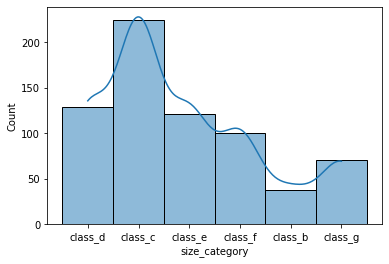

In [ ]:
sns.histplot(y,kde=True,stat='count')

The classes are not perfect normal distributions.

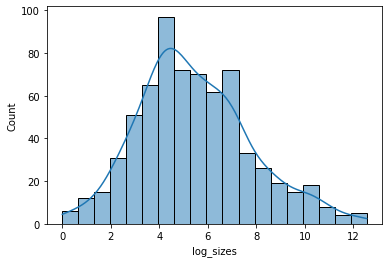

In [ ]:
sns.histplot(X,x='log_sizes',kde=True)

Nor is the log_sizes (continous)

In [ ]:
def test_GaussianNB():
    clf=GaussianNB()
    clf.fit(train_data,train_labels)
    pred_Gaussian = clf.predict(test_data)
    F1_GaussianNB=f1_score(test_labels,pred_Gaussian,average='micro')
    print('The F1 score for GaussianNB is ',F1_GaussianNB)
test_GaussianNB()

The F1 score for GaussianNB is  0.5547445255474452


In [ ]:
def test_CategoricalNB():
    # set minimun as the base
    base = X.describe().loc["min"]
    trans_X_data = pd.DataFrame()
    trans_test_data = pd.DataFrame()
    #X must not contain negative values for CategoricalNB
    for i, col in enumerate(X.columns):
        trans_X_data[col] = X[col].apply(lambda x: x-base[i])
        trans_test_data[col] = test_data[col].apply(lambda x: x-base[i])
    clf = CategoricalNB()
    clf.fit(trans_X_data, y)
    pred_Categorical=clf.predict(trans_test_data)
    F1_CategoricalNB=f1_score(test_labels,pred_Categorical,average='micro')
    print('The F1 score for CategoricalNB is ',F1_CategoricalNB)
    print(trans_X_data)
test_CategoricalNB()

The F1 score for CategoricalNB is  0.9416058394160584
     Latitude  Longitude    Size  ...  windSpeed12  windSpeed13  windSpeed14
0     1.23510    6.54461    99.0  ...     2.050417     1.524167     1.223333
1     0.60030    7.21211    24.0  ...     7.257083     5.182917     2.597083
2     4.93530    5.68767   839.0  ...     2.600000     5.578333     6.555417
3     1.43620    6.36239   891.0  ...     2.902500     2.754583     2.455417
4     0.43590    7.17933    14.0  ...     3.555417     4.141250     3.527083
..        ...        ...     ...  ...          ...          ...          ...
676   2.01982    5.46461  6048.0  ...     7.393750     2.252083     0.738333
677   1.64922    5.57072   421.0  ...     4.315000     1.637083     0.551667
678   2.08698    5.76419  1351.0  ...     5.492917     5.261250     3.134167
679   0.19700    7.57600   264.0  ...     3.491250     2.540833     2.040833
680   2.05700    5.44600  3379.0  ...     3.107917     1.577500     1.977917

[681 rows x 178 colum

In [ ]:
def test_MultinomialNB():
    base = X.describe().loc["min"]
    trans_train_data = pd.DataFrame()
    trans_test_data = pd.DataFrame()
    for i, col in enumerate(X.columns):
        trans_train_data[col] = train_data[col].apply(lambda x: x-base[i])
        trans_test_data[col] = test_data[col].apply(lambda x: x-base[i])
    clf=MultinomialNB()
    clf.fit(trans_train_data, train_labels)
    pred_Multinomial = clf.predict(trans_test_data)
    F1_MultinomialNB=f1_score(test_labels,pred_Multinomial,average='micro')
    print('The F1 score for MultinomialNB is ',F1_MultinomialNB)
test_MultinomialNB()

The F1 score for MultinomialNB is  0.8248175182481752


## K-Nearest-Neighbors

KNN model works well with our data because it can be used on classes, determining if a data point belongs to one class or another. Our fires are categorized into different classes and the accuracy scores further prove this model is effective.

Producing a k-Nearest-Neighbords model with various k values. Evaluating the performance of the model with the highest score with a classification report. 

In [ ]:
k_values = [1,3,5,10, 25, 50, 75, 100]

#add scores for each k_value
scores = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors =k)
    model.fit(train_data, train_labels)
    score = model.score(dev_data, dev_labels)
    scores.append(score)
percent = (np.array(scores)*100)

#go through each k_value to fit the model
test_predicted_labels = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors =k)
    model.fit(train_data, train_labels)
    test_predicted_labels.append(model.predict(dev_data))

#creating a table to easily visualize K value to corresponding score
kdf = {'K Values': k_values, 'Scores': percent}
kdft = pd.DataFrame(kdf, columns = ['K Values', 'Scores'])
#sorting the table by highest scores
kdft.sort_values(by = 'Scores', ascending=False)

,K Values,Scores
2,5,94.117647
0,1,91.911765
1,3,91.911765
3,10,91.176471
4,25,90.441176
5,50,85.294118
6,75,73.529412
7,100,63.235294


In [ ]:
#create classifcation report for 5-Nearest Neighbor (the one that produced the highest score)
model1 = KNeighborsClassifier(n_neighbors =5)
model1.fit(train_data, train_labels)
print(classification_report(dev_labels, model1.predict(dev_data)))


              precision    recall  f1-score   support

     class_b       1.00      0.50      0.67         8
     class_c       0.90      0.96      0.93        48
     class_d       0.93      0.96      0.94        26
     class_e       1.00      1.00      1.00        21
     class_f       0.95      1.00      0.97        18
     class_g       1.00      0.93      0.97        15

    accuracy                           0.94       136
   macro avg       0.96      0.89      0.91       136
weighted avg       0.94      0.94      0.94       136



*Class* A is not included in the classification report because there are no class_a fires in the dev dataset.

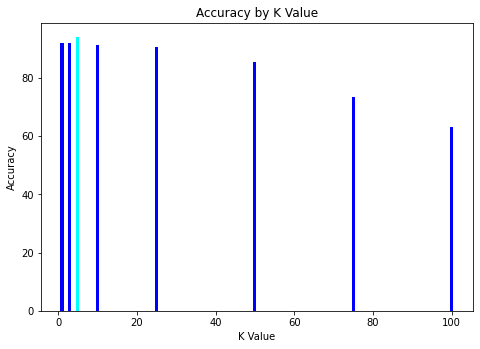

In [ ]:
#Bar plot to further visualize the K Value and corresponding scores
width = 0.5
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
percent = np.array(scores) * 100
ax.bar(k_values, percent, color=('blue','blue', 'cyan','blue','blue','blue', 'blue'))
ax.set_ylabel('Accuracy')
ax.set_xlabel('K Value')
ax.set_title('Accuracy by K Value')
plt.show()

The values 75 and 100 produce fairly low scores, which is understandable since the training data has about 400 points, so the model would be classifiying based on groups that comprise of the majority of the training set. The K-Nearest Neighbor value of 5 produces the highest score of 94.1%

## PCA

PCA is used to speed up machine learning algorithms when the input dimension is too high by reducing multiple-dimensional data into fewer dimensions, (in our case 2) so that we can plot and understand the data better. PCA does so by computing a new set of variables called “principal components” and expresses the data in terms of these new variables. 


In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

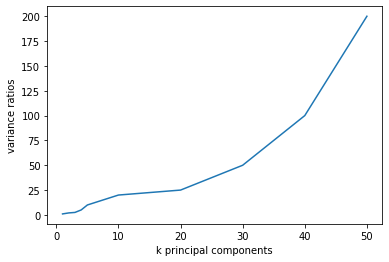

In [ ]:
#PCA Model 

#Principal components (k in list)
components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    
#Create empty list to store variation ratios
store = np.empty(len(components))
    
#for loop to do PCA on each component value in list
for i in components:
    pca = PCA(n_components = i)
    pca.fit_transform(train_data_pca)
    variance_ratio = pca.explained_variance_ratio_.cumsum()
        
#Plot components vs variance ratios
plt.plot(components, store)
plt.xlabel('k principal components')
plt.ylabel('variance ratios')
plt.show()

We ran a for loop to run PCA on the data with varying numbers of principal components to analyze the variance ratios produced. The explained variance ratio is the ratio between the variance of that principal component and the total variance (sum of variances of all individual principal components), indicating how much variance each variable explains. 


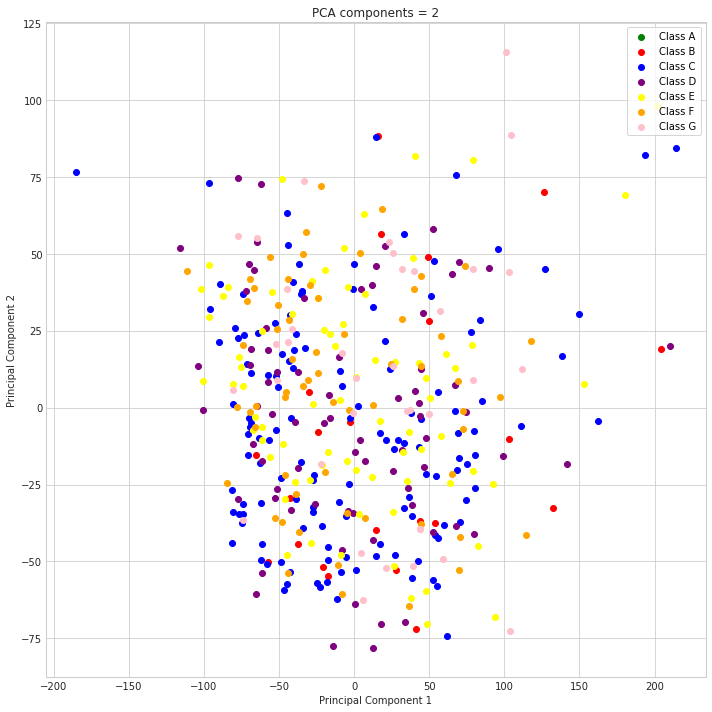

In [ ]:
#Create PCA model and fit on training data 
pca = PCA(n_components = 2)
y_pca = pca.fit_transform(train_data_pca)


#Create plot of 7 PCA components, label with color by class  
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize = (10,10))
    for lab, col in zip(('class_a', 'class_b', 'class_c', 'class_d', 'class_e', 'class_f', 'class_g'),
                        ('green', 'red', 'blue', 'purple', 'yellow', 'orange', 'pink')):
        plt.scatter(y_pca[train_labels_pca==lab, 0],
                    y_pca[train_labels_pca==lab, 1],
                    label=lab,
                    c=col)
            
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA components = 2')
plt.legend(["Class A", "Class B", "Class C", "Class D", "Class E", "Class F", "Class G"], loc='upper right')
plt.tight_layout()
plt.show()

After creating the PCA model, we projected the training data down to 2 principal components in order to visualize the data. Each input was labeled by class and corresponding color to determine visually if clustering or trends occurred. The data seemed to be scattered randomly and no obvious clusters or trends were seen. This could be explained by the large number of features that play into fire size and are affected by different combinations of features occuring at the same time. By reducing all our features down to 2 dimensions, we lose a lot of information that could help us determine trends. 

## Multinomial Logistic Regression

Now we'll use Multinomial Logistic Regression to model the probability of a certain fire class size. Since this is a multiclass classification problem we use the one-versus-rest method for using binary classification algorithms for multi-class classification. Similar to project two we also find the optimal value for the regularization strength C using l2 regularization.

In [ ]:
%%capture

inv_regul_str = np.concatenate([np.arange(0.01,0.1,0.01),np.arange(0.1,0.5,0.02),
                                    np.arange(0.5,2,0.1),np.arange(2,8,1)])

# C is the inverse of regularization strength
# So smaller values specify stronger regularization

param = {'C': list(inv_regul_str)}
best_param_Logit = GridSearchCV(LogisticRegression(penalty='l2', multi_class='ovr'), param, scoring='f1_macro')
best_param_Logit.fit(train_data, train_labels)
optimal_C = best_param_Logit.best_params_['C']

Logit_model = LogisticRegression(penalty='l2', C=optimal_C, multi_class='ovr',random_state=0)
Logit_model.fit(train_data, train_labels)
dev_predicted_labels = Logit_model.predict(dev_data) 


In [ ]:
print('The optimal value for C is {0}.'.format(optimal_C))

The optimal value for C is 7.0.


### Measuring Model Performance 

In [ ]:
# Predict the labels of dev data
# Uses the information the model learned during the model training process
# Test model accuracy 

Logit_model_score = Logit_model.score(dev_data, dev_labels)
Logit_model_score

print('Accuracy score for our Logistic Regression classifier: %s' % Logit_model_score, 'of the time.')
print('F1 score for our Logistic Regression classifier using the optimal value for C: {0:.4f}.'.format(metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,
                                             average='macro')))

Accuracy score for our Logistic Regression classifier: 0.7058823529411765 of the time.
F1 score for our Logistic Regression classifier using the optimal value for C: 0.7144.


Where did our model go wrong?

In [ ]:
cm = confusion_matrix(dev_labels, dev_predicted_labels)
cm

array([[ 6,  2,  0,  0,  0,  0],
       [ 0, 40,  6,  1,  1,  0],
       [ 0,  3, 10,  8,  5,  0],
       [ 0,  0,  5, 14,  2,  0],
       [ 0,  0,  1,  5, 12,  0],
       [ 0,  0,  0,  0,  1, 14]])

Text(0.5, 1.0, 'F1 score: 0.7143925009609102')

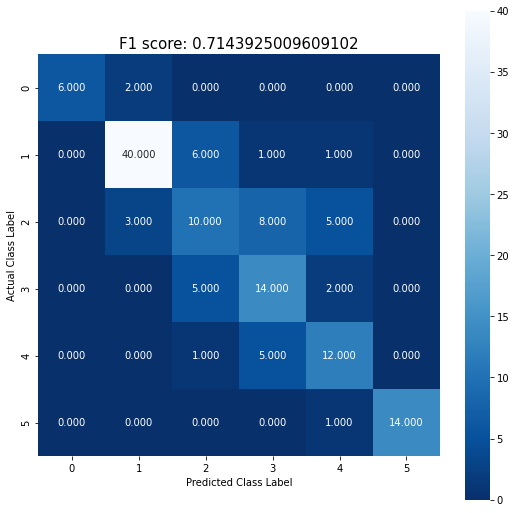

In [ ]:
# Confusion matrix with Seaborn 

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", square=True, cmap = 'Blues_r')
plt.ylabel('Actual Class Label')
plt.xlabel('Predicted Class Label')
dev_sample_title = 'F1 score: {0}'.format(metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,
                                             average='macro'))
plt.title(dev_sample_title, size=15)

As mentioned, there are no class_a fires in our dev set so that is why we only have 6 classes in our confusion matrix ranging from class_b (0) to class_g (5). Class_b was not misclassifed. Class_c was misclassified several times. And classes d, e, and f were the classes that were misclassifed the most. 

## Linear Regression  

As our final model, we were curious if we could use our data to predict fire size (measured in acres) in addition to their class. 
In this case, we used the log transformed fire size data as our outcome variable for two reasons. First, since we're predicting size, using the size labels as the outcome variable no longer makes sense. Second, there were a few outliers we had noticed in our EDA (which we had gone over in our baseline presentation).


In [ ]:
#In this case, the left-hand variable is the log transformed sizes
#Create a new variable that only contains the log_size columns for the train and dev data
lin_reg_train_y = train_data[['log_sizes']]
lin_reg_dev_y = dev_data[['log_sizes']]
lin_reg_train_y.head()

,log_sizes
0,5.236442
1,8.318742
2,5.010635
3,10.126631
4,5.298317


First, we conducted a linear regression model using all the features available. 

In [ ]:
#Create a new dataframe of indicator variables that doesn't include size
lin_reg_train_x = train_data.drop(columns = ['Size','log_sizes'])
lin_reg_dev_x = dev_data.drop(columns= ['Size', 'log_sizes'])
lin_reg_train_x.head()

,Latitude,Longitude,temperature_14,temperature_13,temperature_12,temperature_11,temperature_10,temperature_9,temperature_8,temperature_7,temperature_6,temperature_5,temperature_4,temperature_3,temperature_2,temperature_1,temperature0,temperature1,temperature2,temperature3,temperature4,temperature5,temperature6,temperature7,temperature8,temperature9,temperature10,temperature11,temperature12,temperature13,temperature14,apparentTemperature_14,apparentTemperature_13,apparentTemperature_12,apparentTemperature_11,apparentTemperature_10,apparentTemperature_9,apparentTemperature_8,apparentTemperature_7,apparentTemperature_6,...,pressure4,pressure5,pressure6,pressure7,pressure8,pressure9,pressure10,pressure11,pressure12,pressure13,pressure14,windSpeed_14,windSpeed_13,windSpeed_12,windSpeed_11,windSpeed_10,windSpeed_9,windSpeed_8,windSpeed_7,windSpeed_6,windSpeed_5,windSpeed_4,windSpeed_3,windSpeed_2,windSpeed_1,windSpeed0,windSpeed1,windSpeed2,windSpeed3,windSpeed4,windSpeed5,windSpeed6,windSpeed7,windSpeed8,windSpeed9,windSpeed10,windSpeed11,windSpeed12,windSpeed13,windSpeed14
0,33.68194,-117.39972,73.776667,73.557917,74.040000,73.537917,72.351250,73.099167,73.358333,69.554167,70.938750,73.073750,74.585833,71.509167,71.213333,71.632083,73.347083,76.708750,78.293333,79.790417,76.527083,72.270417,71.457083,73.182917,74.805833,73.417500,73.948333,74.602083,72.800833,71.053333,67.984583,74.460417,73.815833,74.470833,73.816250,72.513333,73.520417,73.831250,69.915000,71.580417,...,1013.225833,1012.362083,1011.861667,1011.972500,1011.728333,1011.945833,1012.001250,1010.705417,1011.106667,1012.465000,1011.724167,2.320000,2.177917,1.983750,2.150833,1.997083,2.057083,2.128333,1.493750,2.019167,2.155417,1.967917,2.063750,2.071667,1.959167,1.865417,1.394583,0.782083,2.056667,2.193750,2.262500,2.112500,1.738333,1.844167,1.837500,1.867083,2.002083,1.996250,1.927917,2.248333
1,34.31100,-117.32200,64.466667,57.216250,55.025000,50.965417,47.996667,55.321250,56.441250,56.250000,57.784167,54.393333,44.025417,45.230417,52.280000,55.781667,59.172500,60.861667,60.407500,60.954583,63.818333,64.845417,61.327917,58.182500,54.897500,57.386250,59.198750,54.798750,47.957500,54.943333,54.484167,64.466667,57.216250,55.025000,50.686250,47.599167,55.321250,56.441250,56.250000,57.784167,...,1015.810000,1013.245833,1012.535000,1012.745417,1013.215417,1014.470833,1014.875000,1012.538333,1010.121250,1016.813333,1017.047083,1.939167,2.684583,1.869167,2.827500,1.885833,2.862917,2.145000,1.585833,1.906250,2.734583,6.017917,2.610417,2.104167,1.361667,1.422917,1.512083,1.730417,1.582917,1.142083,1.065833,1.405833,2.002500,2.440417,2.578333,2.952917,2.266667,4.623750,2.554167,2.536250
2,36.68390,-119.21611,87.258333,87.747917,84.630417,81.019167,80.775000,81.937500,82.001667,83.228333,84.235000,82.009167,79.917500,77.274583,85.211250,86.603750,86.862917,86.470000,85.116250,86.227500,88.398333,88.347500,91.305417,88.896667,85.870417,88.489583,90.161667,90.883333,87.987500,88.833750,87.354583,87.258333,87.747917,84.630417,81.019167,80.775000,81.937500,82.001667,83.228333,84.235000,...,1009.410000,1010.154583,1011.023333,1012.277083,1012.596667,1012.002083,1011.204167,1010.043333,1009.464583,1008.264583,1009.138750,2.742083,2.370833,2.665000,2.167500,2.452917,2.149167,2.222083,2.572083,2.092500,2.395417,5.160833,3.475833,1.629583,2.231667,1.813750,3.488750,2.173750,1.782917,1.940833,2.191667,1.915000,1.138333,1.995833,1.856250,1.873750,1.972083,1.659583,2.586667,2.278750
3,34.77900,-120.09000,59.758750,61.035417,62.762083,60.147500,58.266250,60.171250,60.765833,60.584167,60.810000,62.678750,61.890000,62.536250,65.353333,64.105000,64.917917,63.199583,62.742500,60.073333,59.969167,60.533333,59.299167,60.302500,61.903333,63.437083,62.174167,63.447083,61.750833,61.752083,64.737500,59.758750,61.035417,62.762083,60.147500,58.266250,60.171250,60.765833,60.584167,60.810000,...,1013.631250,1013.620000,1014.477917,1016.804583,1017.482500,1017.042083,1016.193333,1014.598750,1013.547500,101

In [ ]:
#Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(lin_reg_train_x, lin_reg_train_y)

#Test model accuracy with dev data
lin_reg_pred = pd.DataFrame(lin_reg.predict(lin_reg_dev_x))
lin_reg_score = lin_reg.score(lin_reg_dev_x, lin_reg_dev_y)
lin_reg_score

-1.1953441615923661

Looking at the $R^2$ value from the model score, this linear regression very poorly captures the variation within the data, which means that a horizontal line would perform better at predicting fire size than the model's given best linear predictor.

In [ ]:
lin_reg_comparison = lin_reg_dev_y.join(lin_reg_pred)
lin_reg_comparison = lin_reg_comparison.rename(columns= {0: 'predicted'})
lin_reg_comparison

,log_sizes,predicted
0,8.052615,3.815292
1,5.521461,5.127927
2,5.802118,6.329192
3,4.983607,3.508105
4,4.700480,0.045942
...,...,...
131,4.290459,5.277446
132,3.970292,5.545927
133,7.293018,2.325221
134,3.332205,4.941196


Because the feature space is so large (a total of 176 features), this may be a reason for the model's low performance. To improve our model's performance, we conducted PCA on the feature space to reduce the number of feature dimensions.

In [ ]:
#Create several linear regression models to determine if we can accurately predict fire size given weather data
dimensions = np.arange(2,51)
lin_reg_scores = np.array([])

for i in dimensions:
    #Reduce feature space to n dimenions
    pca_nd = PCA(n_components = i)
    lr_train_nd = pca_nd.fit_transform(lin_reg_train_x)
    lr_dev_nd = pca_nd.transform(lin_reg_dev_x)
    lin_reg = LinearRegression() #Fit a linear regression model
    lin_reg.fit(lr_train_nd, lin_reg_train_y)
    #Test model accuracy with dev data
    score = lin_reg.score(lr_dev_nd, lin_reg_dev_y)
    lin_reg_scores = np.append(lin_reg_scores, score)
    
optimal_pca = np.argmax(lin_reg_scores)
lr_best_score = max(lin_reg_scores)
print("Optimal value for n_components for PCA when fitting a linear regression model: %s" %(optimal_pca+2))
print("The best model score for a linear regression model is: %s" %round(lr_best_score,4))

Optimal value for n_components for PCA when fitting a linear regression model: 16
The best model score for a linear regression model is: 0.1438


We found that reducing the feature space to 16 dimensions produced the highest $R^2$ value for our model: 0.1438.

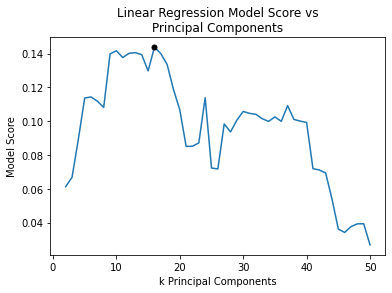

In [ ]:
plt.plot(dimensions,lin_reg_scores)
plt.xlabel("k Principal Components")
plt.ylabel("Model Score")
plt.title("Linear Regression Model Score vs\nPrincipal Components")
plt.plot([16], [lr_best_score], marker='o', markersize=5, color="black")

In [ ]:
#Compare predicted and actual values when n_components=16
pca_16d = PCA(n_components = 16)
lr_train_16d = pca_nd.fit_transform(lin_reg_train_x) 
lr_dev_nd = pca_nd.transform(lin_reg_dev_x)

#Fit a linear regression model with the transformed feature data
lin_reg = LinearRegression() 
lin_reg.fit(lr_train_16d, lin_reg_train_y)
lin_reg_pred = pd.DataFrame(lin_reg.predict(lr_dev_nd))
lin_reg_comparison2 = lin_reg_dev_y.join(lin_reg_pred)
lin_reg_comparison2 = lin_reg_comparison2.rename(columns= {0: 'predicted'})
lin_reg_comparison2

,log_sizes,predicted
0,8.052615,4.591681
1,5.521461,5.165711
2,5.802118,8.600421
3,4.983607,3.921614
4,4.700480,4.268586
...,...,...
131,4.290459,4.482017
132,3.970292,4.442077
133,7.293018,3.823545
134,3.332205,5.873307


Although our model only captures about 14% of the variation in the data, this may make sense given the fact that fire condictions can vary so widely depending on their geographic location, the weather conditions, other environmental factors, and even human-related factors, such as the proactiveness of a county to prevent wildfires. Still, more features may be needed to more accurately predict fire size.

##**Conclusion**

The best performing models are categorical naive bayes and knn with accuracy scores of 94%. Since our data contains discrete features it is understandable that these models performed the best in classifying for each category of wildfire size. 

We are able to predict with fairly high accuracy wildfire size based on weather elements 14 days before and after the start of the fire. This information can be highly useful in containing fires, however it is still important to note that human actions are necessary to reduce the increasingly harmful effects of climate change.
